In [60]:
import pandas as pd
import locale
import glob
import chardet
import numpy as np

# Load data

In [61]:
def read_data_per_file(file: str) -> pd.DataFrame:
    """
    Reads data from a CSV file and returns it as a pandas DataFrame. Handles skipping rows

    Args:
        file (str): The path to the CSV file.

    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV file.
    """
    # Detect the encoding
    with open(file, 'rb') as f:
        result = chardet.detect(f.read())
        encoding = result['encoding']
    data =  pd.read_csv(file, encoding=encoding, skiprows=2)
        
    return data

In [62]:
def load_visitor_counts_data(
    data_folder: str,
) -> pd.DataFrame:
    """
    Loads visitor counts data from multiple CSV files in the specified folder and deletes some unnecessary column.

    Args:
        data_folder (str): The path to the folder containing the CSV files.

    Returns:
        pd.DataFrame: The DataFrame containing the visitor counts data.
    """
    # Read data from CSV files

    raw_visitor_counts = pd.concat([read_data_per_file(
        file
    ) for file in glob.glob(f"{data_folder}/*.csv")])
    
    # Drop last empty column
    visitor_counts = raw_visitor_counts.drop(columns=["Unnamed: 96"])

    return visitor_counts

visitor_counts = load_visitor_counts_data(data_folder="data\manual_visitor_counts")

# Cleaning

### Format date

In [63]:
def parse_german_dates(
    df: pd.DataFrame,
    date_column_name: str
) -> pd.DataFrame:
    """
    Parses German dates in the specified date column of the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the date column.
        date_column_name (str): The name of the date column.

    Returns:
        pd.DataFrame: The DataFrame with parsed German dates.
    """
    
    # Set German locale
    locale.setlocale(locale.LC_TIME, "de_DE.UTF-8")
    
    # Mapping of German month names to their English equivalents
    month_map = {
        "Jan.": "Jan",
        "Feb.": "Feb",
        "März": "Mar",
        "Apr.": "Apr",
        "Mai": "May",
        "Juni": "Jun",
        "Juli": "Jul",
        "Aug.": "Aug",
        "Sep.": "Sep",
        "Okt.": "Oct",
        "Nov.": "Nov",
        "Dez.": "Dec"
    }

    # Replace German month names with English equivalents
    for german, english in month_map.items():
        df[date_column_name] = df[date_column_name].str.replace(german, english)

    # Parse the dates
    df[date_column_name] = pd.to_datetime(df[date_column_name], format="mixed")

    return df

visitor_counts_parsed_dates = parse_german_dates(df=visitor_counts, date_column_name="Time")

### Duplicated Indexes

In [64]:
#for some reason there are duplicated index

visitor_counts_parsed_dates.index.duplicated()

array([False, False, False, ...,  True,  True,  True])

In [65]:
# reset the index to avoid future problems
visitor_counts_parsed_dates = visitor_counts_parsed_dates.reset_index(drop=True)

### Mapping

After reviewing all the columns to check for inconsistencies I arrived to a list of tasks that should be done to clean de dataset:

- Drop repeated columns listed in "to_drop"
- Create "Bucina_Multi IN" as the sum of cyclist and pedestrians it's not there
- Rename columns that had wrong names


In [66]:
#lists an dictionaries to drop and rename

to_drop = ['Brechhäuslau Fußgänger IN', 'Brechhäuslau Fußgänger OUT', 'Waldhausreibe Channel 1 IN', 'Waldhausreibe Channel 2 OUT']

to_create = ['Bucina_Multi IN']


to_rename = {'Bucina IN': 'Bucina PYRO IN',
          'Bucina OUT': 'Bucina PYRO OUT',
          'Gsenget IN.1': 'Gsenget Fußgänger IN',
          'Gsenget OUT.1': 'Gsenget Fußgänger OUT',
          'Gfäll Fußgänger IN' : 'Gfäll IN',
          'Gfäll Fußgänger OUT': 'Gfäll OUT',
          'Fredenbrücke Fußgänger IN' : 'Fredenbrücke IN',
          'Fredenbrücke Fußgänger OUT': 'Fredenbrücke OUT',
          'Diensthüttenstraße Fußgänger IN': 'Diensthüttenstraße IN' ,
          'Diensthüttenstraße Fußgänger OUT': 'Diensthüttenstraße OUT',
          'Racheldiensthütte Cyclist OUT' : 'Racheldiensthütte Fahrräder OUT',
          'Racheldiensthütte Pedestrian IN' : 'Racheldiensthütte Fußgänger IN',
          'Racheldiensthütte Pedestrian OUT' : 'Racheldiensthütte Fußgänger OUT',
          'Sagwassersäge Fußgänger IN' : 'Sagwassersäge IN',
          'Sagwassersäge Fußgänger OUT': 'Sagwassersäge OUT',
          'Schwarzbachbrücke Fußgänger IN' : 'Schwarzbachbrücke IN',
          'Schwarzbachbrücke Fußgänger OUT' : 'Schwarzbachbrücke OUT',
          'NPZ_Falkenstein IN' : 'Falkenstein 1 PYRO IN',
          'NPZ_Falkenstein OUT' : 'Falkenstein 1 PYRO OUT',
          'TFG_Falkenstein_1 Fußgänger zum Parkplatz' : 'Falkenstein 1 OUT',
          'TFG_Falkenstein_1 Fußgänger zum HZW' : 'Falkenstein 1 IN',
          'TFG_Falkenstein_2 Fußgänger In Richtung Parkplatz' : 'Falkenstein 2 OUT',
          'TFG_Falkenstein_2 Fußgänger In Richtung TFG' : 'Falkenstein 2 IN',
          'TFG_Lusen_1 IN' : 'Lusen 1 PYRO IN',
          'TFG_Lusen_1 OUT' : 'Lusen 1 PYRO OUT',
          'TFG_Lusen_1 Fußgänger Richtung TFG': 'Lusen 1 EVO IN',
          'TFG_Lusen_1 Fußgänger Richtung Parkplatz' : 'Lusen 1 EVO OUT',
          'TFG_Lusen_2 Fußgänger Richtung Vögel am Waldrand': 'Lusen 2 IN',
          'TFG_Lusen_2 Fußgänger Richtung Parkplatz' : 'Lusen 2 OUT',
          'TFG_Lusen_3 TFG Lusen 3 IN': 'Lusen 3 IN',
          'TFG_Lusen_3 TFG Lusen 3 OUT': 'Lusen 3 OUT',
          'Waldspielgelände_1 IN': 'Waldspielgelände IN',
          'Waldspielgelände_1 OUT': 'Waldspielgelände OUT',
          'Wistlberg Fußgänger IN' : 'Wistlberg IN',
          'Wistlberg Fußgänger OUT' : 'Wistlberg OUT',
          'Trinkwassertalsperre IN' : 'Trinkwassertalsperre PYRO IN', 
          'Trinkwassertalsperre OUT' : 'Trinkwassertalsperre PYRO OUT'
          }

In [67]:
#Create copy of visitors_counts_parsed_dates
df = visitor_counts_parsed_dates.copy()

# Rename columns
df.rename(columns=to_rename, inplace=True)

# Drop columns
df.drop(columns=to_drop, inplace=True)

# Create Bucina Multi IN
df['Bucina_Multi IN'] = df["Bucina_Multi Fahrräder IN"] + df["Bucina_Multi Fußgänger IN"]

### Timestamp problems

In [68]:
# Check gap between entries: Every jump should be of one hour, but we can see in the print before that there are 7 gaps of 2hs and 7 of 0hs

intervals = df.Time.diff().dropna()

intervals.value_counts()

Time
0 days 01:00:00         61328
0 days 02:00:00             7
0 days 00:00:00             7
-2556 days +01:00:00        1
Name: count, dtype: int64

In [69]:
# Find the first interval to use as a reference
reference_interval = intervals.iloc[0]

# Check where the intervals differ from the reference interval
different_intervals = intervals[intervals != reference_interval]

print("Intervals that differ from the reference interval:")
print(different_intervals)

Intervals that differ from the reference interval:
1994         0 days 02:00:00
1995         0 days 00:00:00
10898        0 days 02:00:00
10899        0 days 00:00:00
19634        0 days 02:00:00
19635        0 days 00:00:00
28370        0 days 02:00:00
28371        0 days 00:00:00
37106        0 days 02:00:00
37107        0 days 00:00:00
45842        0 days 02:00:00
45843        0 days 00:00:00
52584   -2556 days +01:00:00
54602        0 days 02:00:00
54603        0 days 00:00:00
Name: Time, dtype: timedelta64[ns]


While checking the rows we discovered that these rows are the only that have NaN values for all columns

In [70]:
pd.set_option('display.max_columns', None)
df[df.loc[:, df.columns != "Time"].isna().all(axis=1)]

,Time,Bayerisch Eisenstein IN,Bayerisch Eisenstein OUT,Bayerisch Eisenstein Fußgänger IN,Bayerisch Eisenstein Fußgänger OUT,Bayerisch Eisenstein Fahrräder IN,Bayerisch Eisenstein Fahrräder OUT,Brechhäuslau IN,Brechhäuslau OUT,Bucina PYRO IN,Bucina PYRO OUT,Bucina_Multi OUT,Bucina_Multi Fußgänger IN,Bucina_Multi Fahrräder IN,Bucina_Multi Fahrräder OUT,Bucina_Multi Fußgänger OUT,Deffernik IN,Deffernik OUT,Deffernik Fahrräder IN,Deffernik Fahrräder OUT,Deffernik Fußgänger IN,Deffernik Fußgänger OUT,Diensthüttenstraße IN,Diensthüttenstraße OUT,Felswandergebiet IN,Felswandergebiet OUT,Ferdinandsthal IN,Ferdinandsthal OUT,Fredenbrücke IN,Fredenbrücke OUT,Gfäll IN,Gfäll OUT,Gsenget IN,Gsenget OUT,Gsenget Fußgänger IN,Gsenget Fußgänger OUT,Gsenget Fahrräder IN,Gsenget Fahrräder OUT,Klingenbrunner Wald IN,Klingenbrunner Wald OUT,Klingenbrunner Wald Fußgänger IN,Klingenbrunner Wald Fußgänger OUT,Klingenbrunner Wald Fahrräder IN,Klingenbrunner Wald Fahrräder OUT,Klosterfilz IN,Klosterfilz OUT,Klosterfilz Fußgänger IN,Klosterfilz Fußgänger OUT,Klosterfilz Fahrräder IN,Klosterfilz Fahrräder OUT,Falkenstein 1 PYRO IN,Falkenstein 1 PYRO OUT,Racheldiensthütte IN,Racheldiensthütte OUT,Racheldiensthütte Fahrräder IN,Racheldiensthütte Fahrräder OUT,Racheldiensthütte Fußgänger IN,Racheldiensthütte Fußgänger OUT,Sagwassersäge IN,Sagwassersäge OUT,Scheuereck IN,Scheuereck OUT,Schillerstraße IN,Schillerstraße OUT,Schwarzbachbrücke IN,Schwarzbachbrücke OUT,Falkenstein 1 OUT,Falkenstein 1 IN,Falkenstein 2 OUT,Falkenstein 2 IN,TFG_Lusen IN,TFG_Lusen OUT,Lusen 1 EVO IN,Lusen 1 EVO OUT,Lusen 2 IN,Lusen 2 OUT,Lusen 3 IN,Lusen 3 OUT,Trinkwassertalsperre PYRO IN,Trinkwassertalsperre PYRO OUT,Trinkwassertalsperre_MULTI IN,Trinkwassertalsperre_MULTI OUT,Trinkwassertalsperre_MULTI Fußgänger IN,Trinkwassertalsperre_MULTI Fußgänger OUT,Trinkwassertalsperre_MULTI Fahrräder IN,Trinkwassertalsperre_MULTI Fahrräder OUT,Waldhausreibe IN,Waldhausreibe OUT,Waldspielgelände IN,Waldspielgelände OUT,Wistlberg IN,Wistlberg OUT,Bucina_Multi IN
1994,2018-03-25 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10898,2019-03-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19634,2020-03-29 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28370,2021-03-28 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37106,2022-03-27 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [71]:
print("Example of problem: At the end of march every year skips a line")
print(df[["Time", "Bucina_Multi IN"]][1992: ].head(5))

Example of problem: At the end of march every year skips a line
                    Time  Bucina_Multi IN
1992 2018-03-25 00:00:00              NaN
1993 2018-03-25 01:00:00              NaN
1994 2018-03-25 03:00:00              NaN
1995 2018-03-25 03:00:00              NaN
1996 2018-03-25 04:00:00              NaN


We decided to change every repeated row to fill the "02:00" missing, and imputate that row with the values from the inmediately preceading row

In [72]:
#identify wrong indexes
index_wrong_time = df[df.loc[:, df.columns != "Time"].isna().all(axis=1)].index

# sustract one hour
df.loc[index_wrong_time, 'Time'] = df.loc[index_wrong_time, 'Time'] - pd.Timedelta(hours=1)

# imputate values from the preceding row
for idx in index_wrong_time:
    if idx > 0:  # Ensure the preceding row exists",
        # Copy values from the preceding row",
        df.loc[idx, df.columns != 'Time'] = df.loc[idx - 1, df.columns != 'Time']

Now for further work we can set the Time column as index

In [73]:
df = df.set_index('Time').sort_index()

### Problems with overlaping data

Some sensors have data when they should not. For example Bucina_Multi replaced Bucina PYRO, so when the records for Multi starts, PYRO should be all NaN.

In [74]:
#dict of replaced sensors variables

merge = {'Bucina MERGED IN' : ['Bucina PYRO IN', 'Bucina_Multi IN'],
        'Bucina MERGED OUT' : ['Bucina PYRO OUT', 'Bucina_Multi OUT'],
        'Falkenstein 1 MERGED IN': ['Falkenstein 1 PYRO IN', 'Falkenstein 1 IN'],
        'Falkenstein 1 MERGED OUT':['Falkenstein 1 PYRO OUT', 'Falkenstein 1 OUT'],
        'Lusen 1 MERGED IN':['TFG_Lusen IN', 'Lusen 1 EVO IN'],
        'Lusen 1 MERGED OUT':['TFG_Lusen OUT', 'Lusen 1 EVO OUT'],
        'Trinkwassertalsperre MERGED IN':['Trinkwassertalsperre PYRO IN', 'Trinkwassertalsperre_MULTI IN'],
        'Trinkwassertalsperre MERGED OUT':['Trinkwassertalsperre PYRO OUT', 'Trinkwassertalsperre_MULTI OUT'] 
        }

In [75]:
def check_column_overlap(dataframe, columns_dict):

    """Function to check if some selected columns (the ones that have replaced sensors) have overlapping records"""
    
    for key, columns in columns_dict.items():
        if len(columns) != 2:
            print(f"Error: The value for key '{key}' does not contain exactly two columns.")
            continue
        
        col1, col2 = columns
        
        # Ensure columns exist in the dataframe
        if col1 in dataframe.columns and col2 in dataframe.columns:
            # Check for overlapping non-NaN values
            overlap = (~dataframe[col1].isna()) & (~dataframe[col2].isna())
            if overlap.any():
                print(f"Overlap found in columns: {col1} and {col2}")
            else:
                print(f"No overlap in columns: {col1} and {col2}")
        else:
            print(f"Columns {col1} or {col2} not found in the dataframe")

check_column_overlap(df, merge)

Overlap found in columns: Bucina PYRO IN and Bucina_Multi IN
Overlap found in columns: Bucina PYRO OUT and Bucina_Multi OUT
Overlap found in columns: Falkenstein 1 PYRO IN and Falkenstein 1 IN
Overlap found in columns: Falkenstein 1 PYRO OUT and Falkenstein 1 OUT
No overlap in columns: TFG_Lusen IN and Lusen 1 EVO IN
No overlap in columns: TFG_Lusen OUT and Lusen 1 EVO OUT
Overlap found in columns: Trinkwassertalsperre PYRO IN and Trinkwassertalsperre_MULTI IN
Overlap found in columns: Trinkwassertalsperre PYRO OUT and Trinkwassertalsperre_MULTI OUT


Find the index for when the overlaps start

In [76]:
def find_first_overlap_index(dataframe, columns_dict):
    overlap_indices = {}
    
    for key, columns in columns_dict.items():
        col1, col2 = columns
        
        # Ensure columns exist in the dataframe
        if col1 in dataframe.columns and col2 in dataframe.columns:
            # Check for overlapping non-NaN values
            overlap = (~dataframe[col1].isna()) & (~dataframe[col2].isna())
            if overlap.any():
                first_overlap_index = overlap.idxmax()  # idxmax() returns the first index where condition is True
                overlap_indices[key] = first_overlap_index
            else:
                overlap_indices[key] = None  # No overlap found
        else:
            overlap_indices[key] = None  # Columns not found
    
    return overlap_indices

find_first_overlap_index(df, merge)

{'Bucina MERGED IN': Timestamp('2021-05-28 00:00:00'),
 'Bucina MERGED OUT': Timestamp('2021-05-28 00:00:00'),
 'Falkenstein 1 MERGED IN': Timestamp('2022-12-22 12:00:00'),
 'Falkenstein 1 MERGED OUT': Timestamp('2022-12-22 12:00:00'),
 'Lusen 1 MERGED IN': None,
 'Lusen 1 MERGED OUT': None,
 'Trinkwassertalsperre MERGED IN': Timestamp('2017-01-01 00:00:00'),
 'Trinkwassertalsperre MERGED OUT': Timestamp('2017-01-01 00:00:00')}

Fix overlap for **Trinkwassertalsperre**

In [77]:
replacement_date = '2021-06-18 00:00:00'

multi_columns = ['Trinkwassertalsperre_MULTI Fußgänger IN',
                 'Trinkwassertalsperre_MULTI Fußgänger OUT',
                 'Trinkwassertalsperre_MULTI Fahrräder IN',
                 'Trinkwassertalsperre_MULTI Fahrräder OUT',
                 'Trinkwassertalsperre_MULTI IN',
                 'Trinkwassertalsperre_MULTI OUT'
                 ]

pyro_columns = ['Trinkwassertalsperre PYRO IN',
                'Trinkwassertalsperre PYRO OUT']

# set to nan old values for Multi variables
df.loc[df.index <= replacement_date, multi_columns] = np.nan

# set to nan recent values for PYRO
df.loc[df.index > replacement_date, pyro_columns] = np.nan

Fix overlap for **Bucina**

In [78]:
replacement_date = '2021-05-28 00:00:00'

multi_columns = ['Bucina_Multi OUT',
                 'Bucina_Multi Fußgänger IN', 'Bucina_Multi Fahrräder IN',
                 'Bucina_Multi Fahrräder OUT', 'Bucina_Multi Fußgänger OUT',
                 'Bucina_Multi IN'
                 ]

pyro_columns = ['Bucina PYRO IN', 'Bucina PYRO OUT']

# set to nan old values for Multi variables
df.loc[df.index <= replacement_date, multi_columns] = np.nan

# set to nan recent values for PYRO
df.loc[df.index > replacement_date, pyro_columns] = np.nan

Fix overlap for **Falkenstein 1**

In [79]:
replacement_date = '2022-12-22 12:00:00'

multi_columns = ['Falkenstein 1 OUT',
                 'Falkenstein 1 IN']

pyro_columns = ['Falkenstein 1 PYRO IN', 'Falkenstein 1 PYRO OUT']

# set to nan old values for Multi variables
df.loc[df.index <= replacement_date, multi_columns] = np.nan

# set to nan recent values for PYRO
df.loc[df.index > replacement_date, pyro_columns] = np.nan

**Final Check of Overlaps**

In [80]:
check_column_overlap(df, merge)

No overlap in columns: Bucina PYRO IN and Bucina_Multi IN
No overlap in columns: Bucina PYRO OUT and Bucina_Multi OUT
No overlap in columns: Falkenstein 1 PYRO IN and Falkenstein 1 IN
No overlap in columns: Falkenstein 1 PYRO OUT and Falkenstein 1 OUT
No overlap in columns: TFG_Lusen IN and Lusen 1 EVO IN
No overlap in columns: TFG_Lusen OUT and Lusen 1 EVO OUT
No overlap in columns: Trinkwassertalsperre PYRO IN and Trinkwassertalsperre_MULTI IN
No overlap in columns: Trinkwassertalsperre PYRO OUT and Trinkwassertalsperre_MULTI OUT


### Merge columns for same position

In [81]:
def merge_columns(df, merge_dict):
    # Iterate over each item in the dictionary
    for new_col, cols in merge_dict.items():
        # Combine the two columns into one. Assuming no overlap, you can use fillna.
        df[new_col] = df[cols[0]].combine_first(df[cols[1]])

    return df

df = merge_columns(df, merge)

### Check outliers

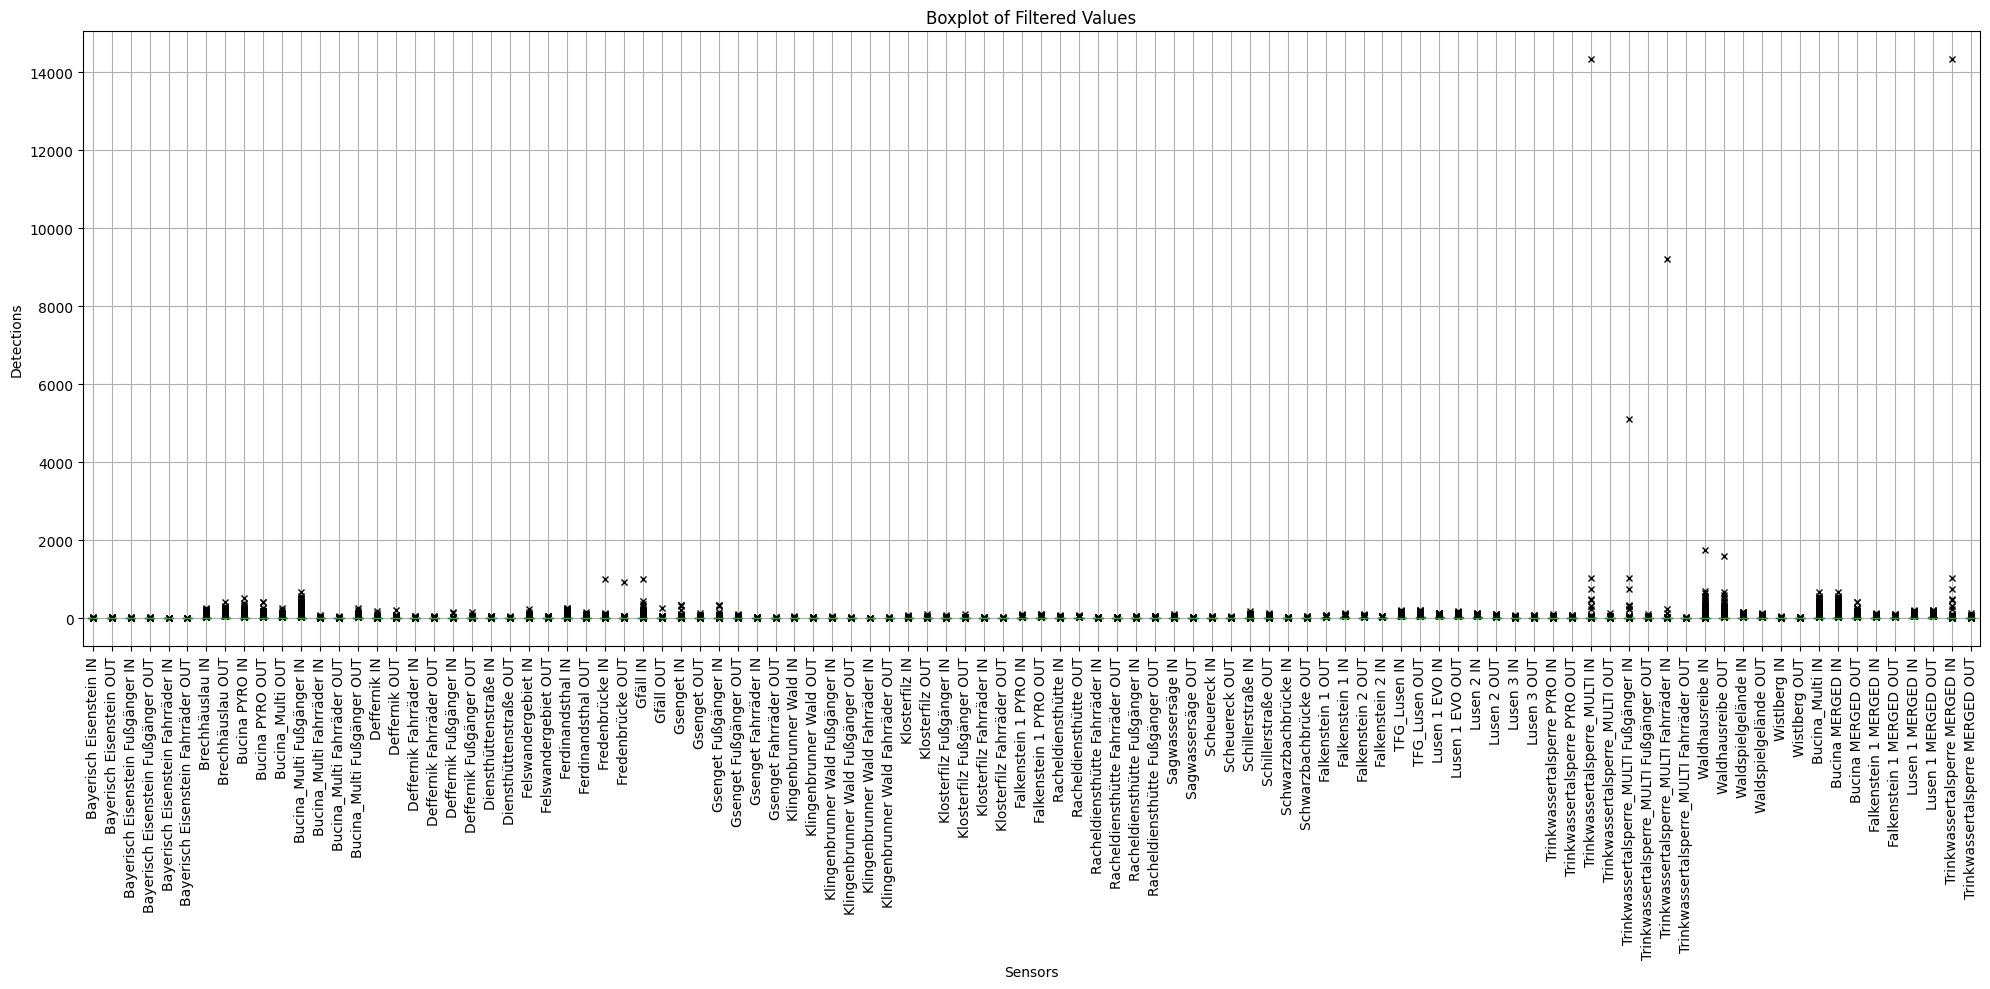

In [82]:
import matplotlib.pyplot as plt

# Replace zero values with NaN
df_filtered = df.replace(0, np.nan)

# Drop rows where all values are NaN (i.e., where all values were zero or greater than 1000)
df_filtered = df_filtered.dropna(how='all')

# Drop columns where all values are NaN (if any column became completely empty)
df_filtered = df_filtered.dropna(axis=1, how='all')

# Check if there are any remaining columns to plot
if not df_filtered.empty and not df_filtered.select_dtypes(include=[np.number]).empty:
    plt.figure(figsize=(20, 10))
    
    # Create the boxplot
    boxplot = df_filtered.boxplot(
        whis=1.5,
        flierprops=dict(marker='x', color='red', markersize=5)
    )
    
    plt.title('Boxplot of Filtered Values')
    plt.xlabel('Sensors')
    plt.ylabel('Detections')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()
else:
    print("No numeric columns available for plotting.")


Rows with count over 800

In [83]:
# Identify columns where any value exceeds 1000
high_value_columns = df.columns[(df > 800).any()]

df_high_value_columns = df[high_value_columns]
df_high_value_columns[df_high_value_columns > 800].dropna(how='all')


,Fredenbrücke IN,Fredenbrücke OUT,Gfäll IN,Trinkwassertalsperre_MULTI IN,Trinkwassertalsperre_MULTI Fußgänger IN,Trinkwassertalsperre_MULTI Fahrräder IN,Waldhausreibe IN,Waldhausreibe OUT,Trinkwassertalsperre MERGED IN
Time,,,,,,,,,
2017-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1752.0,1593.0,NaN
2021-02-04 09:00:00,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-04 23:00:00,1011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-06 05:00:00,NaN,944.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-07 10:00:00,NaN,NaN,NaN,14328.0,5116.0,9212.0,NaN,NaN,14328.0
2022-05-08 11:00:00,NaN,NaN,NaN,1040.0,1040.0,NaN,NaN,NaN,1040.0


There are only 6 rows with values over 800, and they are isolated. We will replace them with NaN



In [84]:
df[df > 800] = np.nan

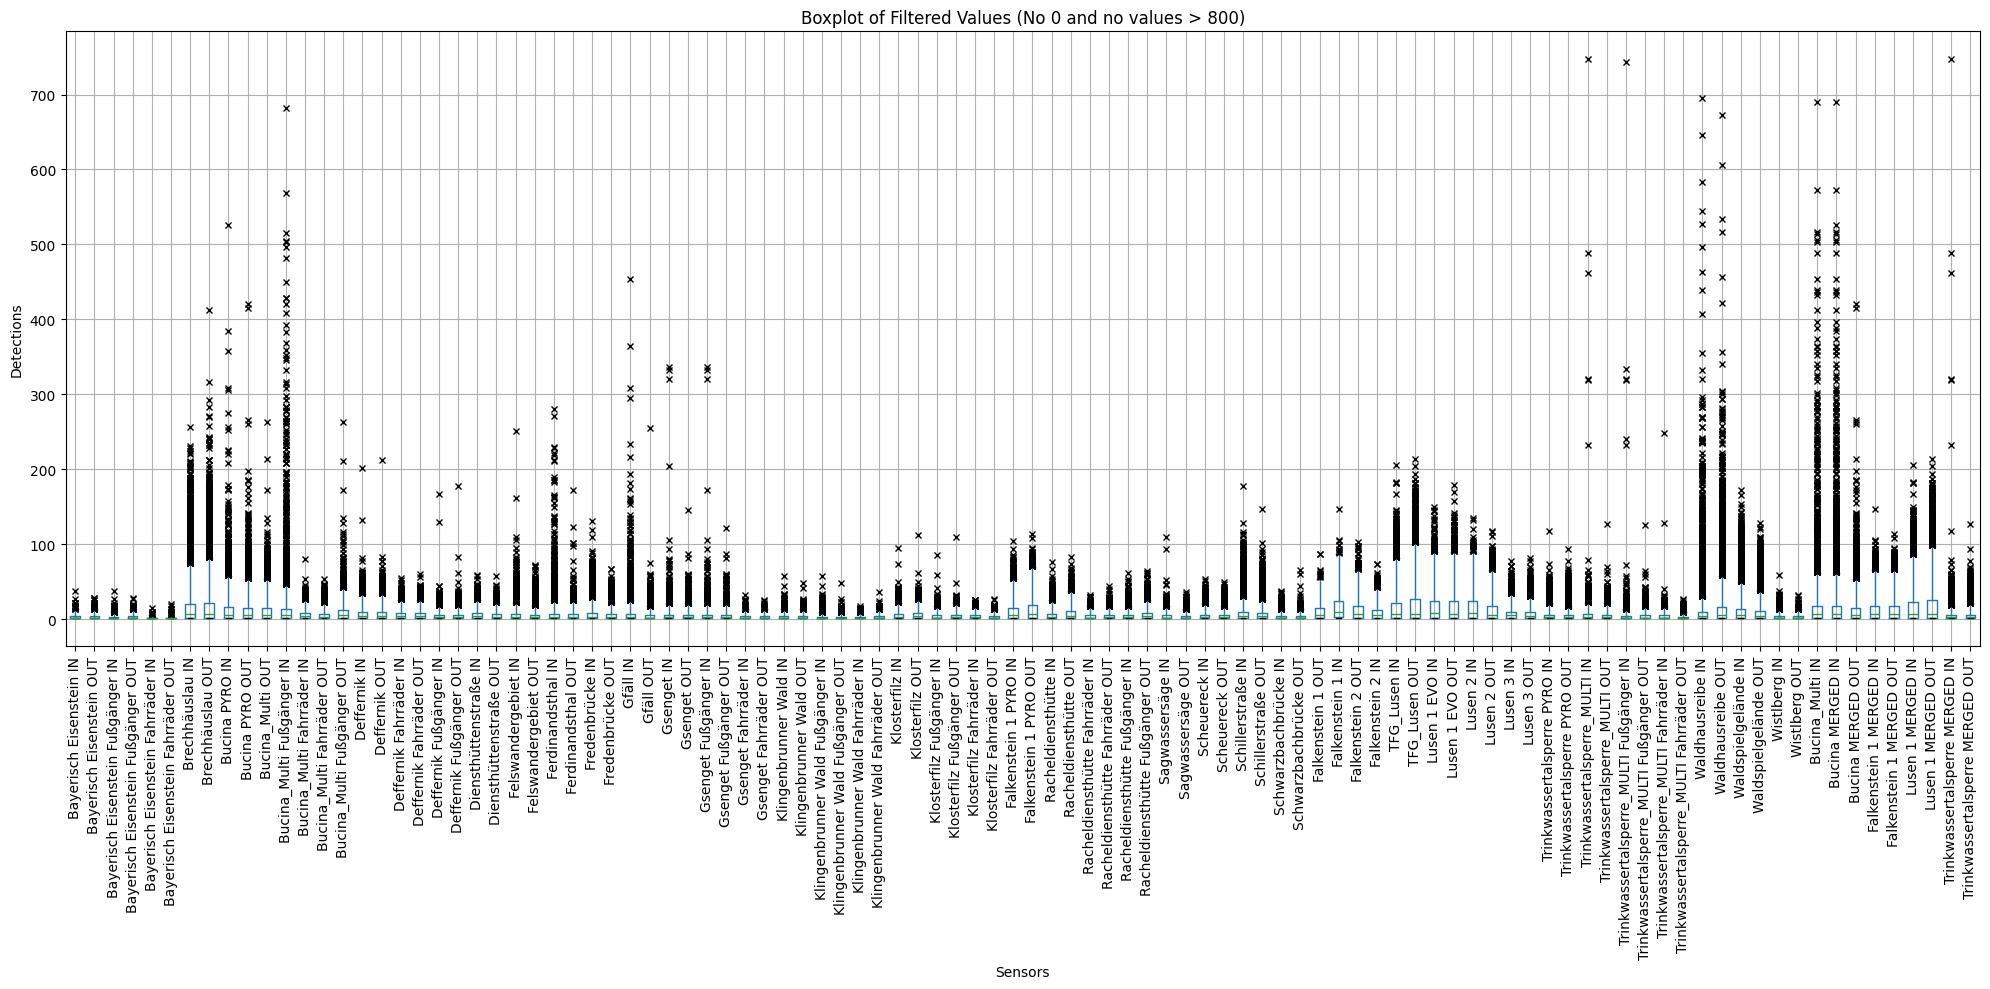

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is already defined earlier in your code

# Replace zero values with NaN to better visualize boxplots
df_filtered = df.replace(0, np.nan)

# Drop rows where all values are NaN (i.e., where all values were zero or greater than 1000)
df_filtered = df_filtered.dropna(how='all')

# Drop columns where all values are NaN (if any column became completely empty)
df_filtered = df_filtered.dropna(axis=1, how='all')

# Check if there are any remaining columns to plot
if not df_filtered.empty and not df_filtered.select_dtypes(include=[np.number]).empty:
    plt.figure(figsize=(20, 10))
    
    # Create the boxplot
    boxplot = df_filtered.boxplot(
        whis=3,
        flierprops=dict(marker='x', color='red', markersize=5)
    )
    
    plt.title('Boxplot of Filtered Values (No 0 and no values > 800)')
    plt.xlabel('Sensors')
    plt.ylabel('Detections')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()
else:
    print("No numeric columns available for plotting.")


### Overview of missing values

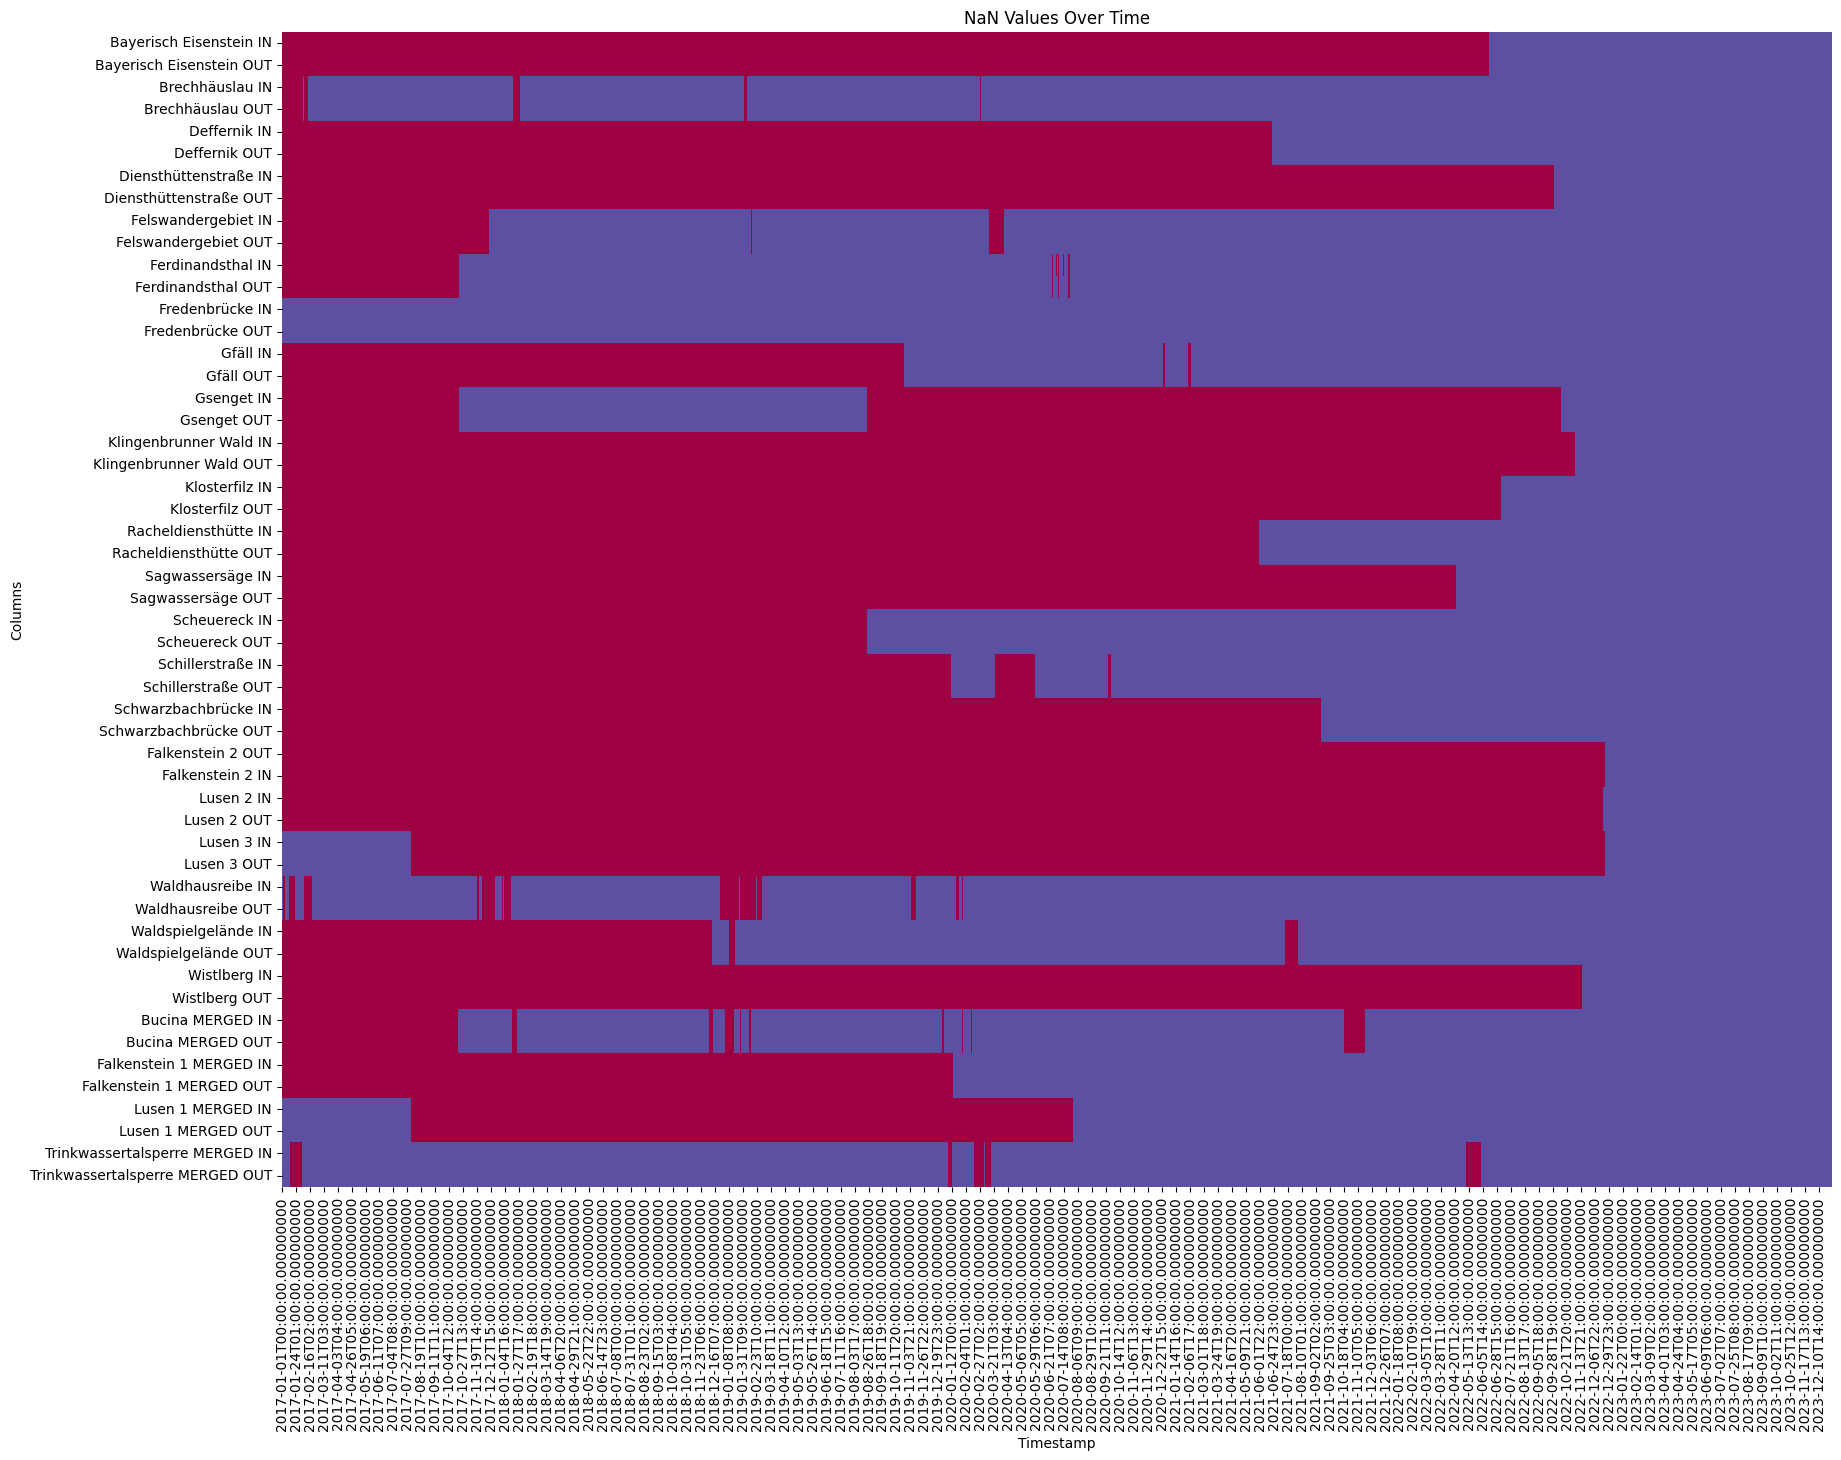

In [86]:
import seaborn as sns
# Create a DataFrame indicating NaN values (True if NaN, False otherwise)

traffic_columns = [col for col in df.columns 
                    if "Fahrräder" not in col 
                    and "Fußgänger" not in col]

traffic_columns = [col for col in traffic_columns 
                    if "Bucina" not in col 
                    and "Trinkwass" not in col
                    and "TFG" not in col
                    and "Lusen 1" not in col
                    and "Falkenstein 1" not in col]

keys_list = list(merge.keys())

for key in keys_list:
    traffic_columns.append(key)


nan_df = df[traffic_columns].isna()

# Set up the plot
plt.figure(figsize=(20, 15))

# Plot the heatmap
sns.heatmap(nan_df.T, cmap='Spectral_r', cbar=False)

# Set axis labels
plt.xlabel('Timestamp')
plt.ylabel('Columns')
plt.title('NaN Values Over Time')

# Show the plot
plt.show()

Given the amount of missing data we will slice the df from 2023 onwards

In [92]:
df_2023 = df.loc["2023-01-01 00:00:00": ,]

# Create target variable for first iteration

- Create a column for the sum of IN and OUT, to have a general representation of traffic with no direction.
- Create another column sustracting from this the OUTS for the park entrances


### Traffic:
Sum of INS and OUTS

In [93]:
# select only aggregated columns for EVO sensors and merged colums for replaced sensors

traffic_columns = [col for col in df_2023.columns 
                    if "Fahrräder" not in col 
                    and "Fußgänger" not in col]

traffic_columns = [col for col in traffic_columns 
                    if "Bucina" not in col 
                    and "Trinkwass" not in col
                    and "TFG" not in col
                    and "Lusen 1" not in col
                    and "Falkenstein 1" not in col]

keys_list = list(merge.keys())

for key in keys_list:
    traffic_columns.append(key)

In [94]:
df_2023['target'] = df_2023[traffic_columns].sum(axis=1)

C:\Users\patricio\AppData\Local\Temp\ipykernel_1892\2901844378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['target'] = df_2023[traffic_columns].sum(axis=1)


Save dataset for joining

In [95]:
df_2023["target"].to_csv(r"C:\Users\patricio\Documents\bf-dssgx\data\historic_sensor_data_traffic_aggregated.csv")

### Occupancy:

Substract the OUTS from sensors located at entrances

In [91]:
"""occup_columns = [col for col in df_2023.columns 
                    if ("Falkenstein" in col 
                    or "Lusen" in col)
                    and "IN" not in col
                    and "3" not in col]

df_2023["occupancy"] = df_2023["target"] - df_2023[occup_columns].sum(axis=1)"""

'occup_columns = [col for col in df_2023.columns \n                    if ("Falkenstein" in col \n                    or "Lusen" in col)\n                    and "IN" not in col\n                    and "3" not in col]\n\ndf_2023["occupancy"] = df_2023["target"] - df_2023[occup_columns].sum(axis=1)'